# Product Amount Forecast by Time

## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

## Indest Data

In [24]:
df = pd.read_csv("Frozen_Dessert_Production.csv",index_col="DATE",parse_dates=["DATE"])
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


## Exploratory Data Analysis and Visualization

1. Implement basic steps to see how is your data looks like
2. Change the column name as "Production"
2. Plot your data and see its seasonalty

In [10]:
df.shape

(573, 1)

In [54]:
df.duplicated().sum()

0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [12]:
df.describe()

,IPN31152N
count,573.000
mean,109.896
std,27.951
min,58.660
25%,88.936
50%,107.643
75%,128.278
max,196.174


<AxesSubplot:xlabel='DATE', ylabel='IPN31152N'>

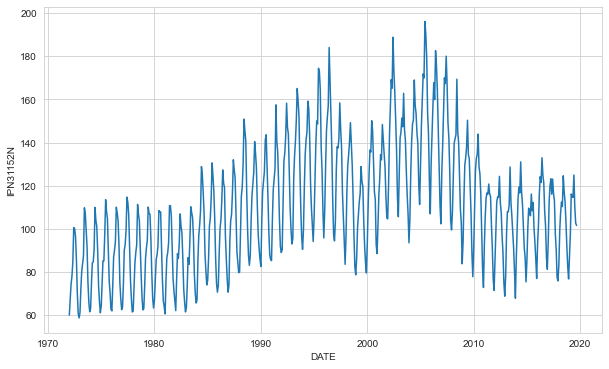

In [61]:
sns.lineplot(x=df.index, y=df["IPN31152N"])

## Preprocessing of Data

### Train Test Split

In [62]:
len(df)

573

In [63]:
test_size = 24

In [64]:
test_ind = len(df) - test_size
test_ind

549

In [65]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [66]:
train

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2017-05-01,116.064
2017-06-01,123.087
2017-07-01,116.264


In [67]:
test

,IPN31152N
DATE,
2017-10-01,90.473
2017-11-01,77.438
2017-12-01,75.812
2018-01-01,83.434
2018-02-01,99.490
2018-03-01,107.315
2018-04-01,112.431
2018-05-01,110.354
2018-06-01,124.584


### Scaling

In [68]:
from sklearn.preprocessing import MinMaxScaler

In [69]:
scaler = MinMaxScaler()

In [70]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [71]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [73]:
length = 12
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)

In [74]:
len(generator)

537

In [75]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]),
 array([[0.01774221]]))

In [76]:
X, y = generator[0]

In [77]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


## Modelling & Model Performance

### Import related libraries

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating Model

### with "tanh" activation function

In [81]:
n_features = train_scaled.shape[1]

In [82]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [83]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [85]:
from tensorflow.keras.callbacks import EarlyStopping

In [86]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [87]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

In [88]:
len(validation_generator)

12

In [89]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 12s 13ms/step - loss: 0.0241 - val_loss: 0.0039
Epoch 2/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 3/20
537/537 [==============================] - 6s 12ms/step - loss: 0.0044 - val_loss: 0.0037
Epoch 4/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 5/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 6/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 7/20
537/537 [==============================] - 6s 11ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 8/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 9/20
537/537 [==============================] - 6s 10ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 10/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0034 - val_l

<AxesSubplot:>

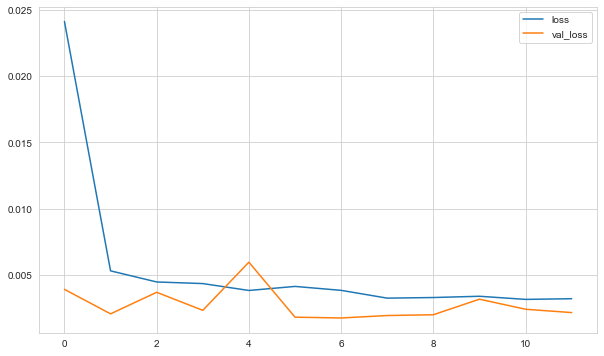

In [91]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

#### Evaluate on Test Data

In [96]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [92]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [93]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

In [94]:
predictions_scaled

[array([0.2259578], dtype=float32),
 array([0.20619579], dtype=float32),
 array([0.23075777], dtype=float32),
 array([0.27834505], dtype=float32),
 array([0.32448423], dtype=float32),
 array([0.36131412], dtype=float32),
 array([0.38940978], dtype=float32),
 array([0.40519577], dtype=float32),
 array([0.40340018], dtype=float32),
 array([0.374206], dtype=float32),
 array([0.3237945], dtype=float32),
 array([0.26593715], dtype=float32)]

In [97]:
eval_metrics(test_scaled[:length], predictions_scaled)

r2_score: 0.7053082932608525 
mae: 0.05005360754592777 
mse: 0.0036749938302226416 
rmse: 0.060621727377423364


#### Inverse Transformations and Comparing

In [98]:
predictions = scaler.inverse_transform(predictions_scaled)

In [99]:
compare = test[:12]

In [100]:
compare['Predictions'] = predictions

In [101]:
compare

,IPN31152N,Predictions
DATE,,
2017-10-01,90.473,89.732
2017-11-01,77.438,87.015
2017-12-01,75.812,90.392
2018-01-01,83.434,96.936
2018-02-01,99.490,103.281
2018-03-01,107.315,108.346
2018-04-01,112.431,112.209
2018-05-01,110.354,114.380
2018-06-01,124.584,114.133


<AxesSubplot:xlabel='DATE'>

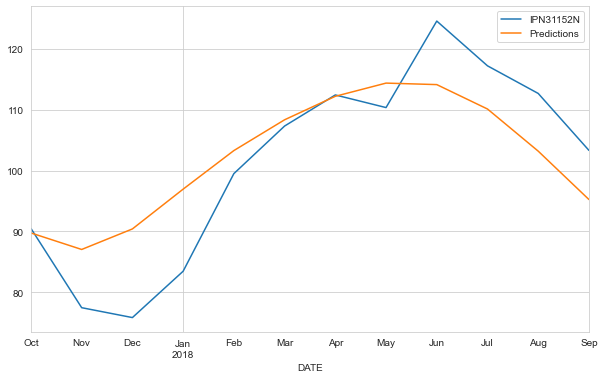

In [102]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [104]:
eval_metrics(compare.IPN31152N, compare.Predictions)

r2_score: 0.7053082932608525 
mae: 6.883066782709958 
mse: 69.49440047660843 
rmse: 8.33633015640626


### with "relu" activation function

In [105]:
model2 = Sequential()
model2.add(LSTM(100, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model2.add(LSTM(50, activation = 'relu'))
model2.add(Dense(1))
model2.compile(optimizer = 'adam', loss = 'mse')

In [106]:
model2.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 9s 10ms/step - loss: 0.0245 - val_loss: 0.0107
Epoch 2/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0141 - val_loss: 0.0042
Epoch 3/20
537/537 [==============================] - 5s 10ms/step - loss: 0.0071 - val_loss: 0.0022
Epoch 4/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0064 - val_loss: 0.0026
Epoch 5/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 6/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 7/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 8/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 9/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 10/20
537/537 [==============================] - 5s 9ms/step - loss: 0.0035 - val_loss: 0.00

<AxesSubplot:>

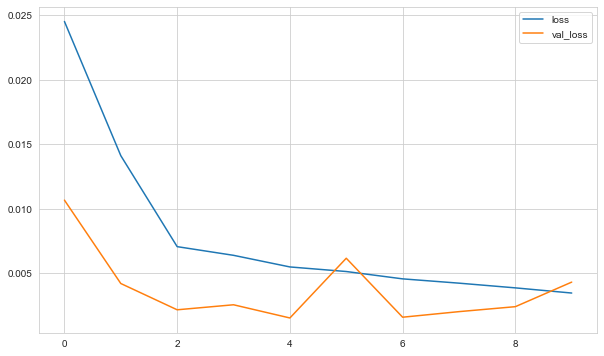

In [107]:
loss_df2 = pd.DataFrame(model2.history.history)
loss_df2.plot()

#### Evaluate on Test Data

In [111]:
predictions_scaled2 = []

first_eval_batch2 = train_scaled[-length:]
current_batch2 = first_eval_batch2.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred2 = model2.predict(current_batch2)
    
    # store prediction
    predictions_scaled2.append(current_pred2[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch2 = np.append(current_batch2[:, 1:, :], [current_pred2], axis=1)

In [112]:
eval_metrics(test_scaled[:length], predictions_scaled2)

r2_score: -0.6764301433300772 
mae: 0.13961700082261433 
mse: 0.020906154780225006 
rmse: 0.14458960813358962


#### Inverse Transformations and Comparing

In [113]:
predictions = scaler.inverse_transform(predictions_scaled2)

In [114]:
compare = test[:12]

In [115]:
compare['Predictions'] = predictions

In [116]:
compare

,IPN31152N,Predictions
DATE,,
2017-10-01,90.473,101.315
2017-11-01,77.438,94.638
2017-12-01,75.812,95.405
2018-01-01,83.434,107.213
2018-02-01,99.490,119.204
2018-03-01,107.315,128.610
2018-04-01,112.431,135.766
2018-05-01,110.354,140.263
2018-06-01,124.584,142.687


<AxesSubplot:xlabel='DATE'>

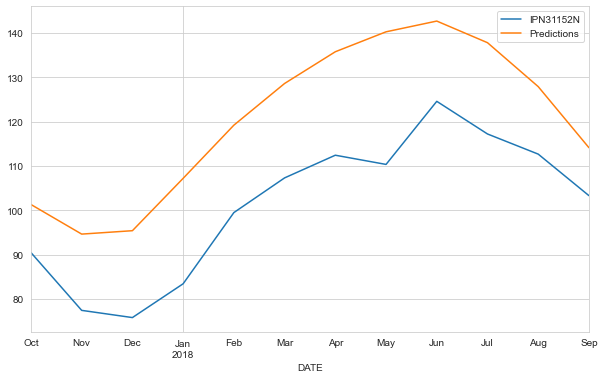

In [117]:
compare.plot()

#### Calculation R2 Score and Error Metrics

In [118]:
eval_metrics(compare.IPN31152N, compare.Predictions)


r2_score: -0.6764301433300761 
mae: 19.199278289420896 
mse: 395.33690662955445 
rmse: 19.883080913921628


## Retrain and Forecasting

Select activation function providing a better score, create your final model with full data, forecast for the next 12 months, and plot this forecast.

tanh is selected as activation function

In [119]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [120]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [121]:
len(df)

573

In [122]:
len(generator)

561

In [123]:
model = Sequential()
model.add(LSTM(100, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(50, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
561/561 [==============================] - 10s 10ms/step - loss: 0.0189
Epoch 2/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0055
Epoch 3/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0048
Epoch 4/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0042
Epoch 5/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0041
Epoch 6/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0035
Epoch 7/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0036
Epoch 8/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0034: 0s 
Epoch 9/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0033
Epoch 10/15
561/561 [==============================] - 6s 11ms/step - loss: 0.0032
Epoch 11/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0031
Epoch 12/15
561/561 [==============================] - 6s 10ms/step - loss: 0.0028
Epoch 1

In [124]:
scaled_full_data.shape

(573, 1)

In [125]:
scaled_full_data[-length:].shape

(12, 1)

In [126]:
forecast = []
# Replace periods with whatever forecast length you want

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [127]:
forecast = scaler.inverse_transform(forecast)

In [128]:
forecast

array([[ 91.56985332],
       [ 85.99448111],
       [ 88.91975106],
       [ 98.61635204],
       [110.09097985],
       [120.05859291],
       [127.52248443],
       [132.53741909],
       [133.76275815],
       [129.085354  ],
       [119.92308072],
       [107.65324806]])

In [130]:
df

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [132]:
forecast_index = pd.date_range(start = '2019-09-01', periods = length, freq = 'MS')

In [133]:
forecast_index

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [134]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [135]:
forecast_df

,Forecast
2019-09-01,91.570
2019-10-01,85.994
2019-11-01,88.920
2019-12-01,98.616
2020-01-01,110.091
2020-02-01,120.059
2020-03-01,127.522
2020-04-01,132.537
2020-05-01,133.763
2020-06-01,129.085


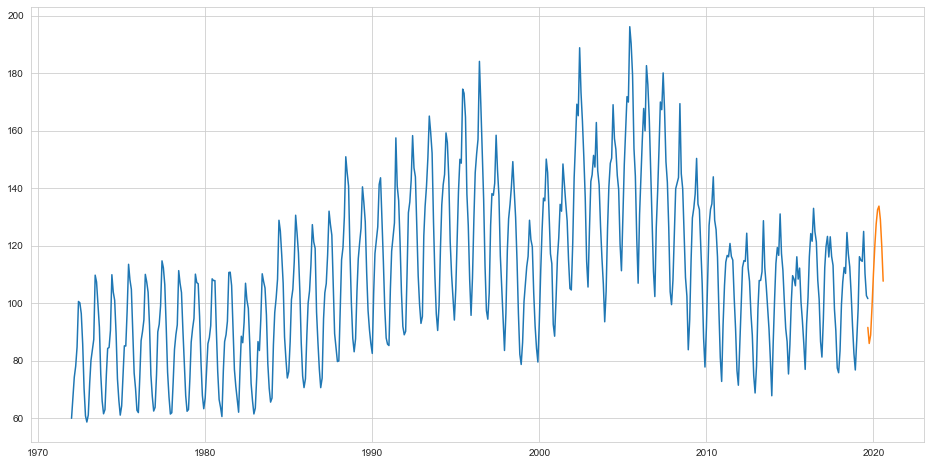

In [137]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['IPN31152N'])
plt.plot(forecast_df.index, forecast_df['Forecast'])

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

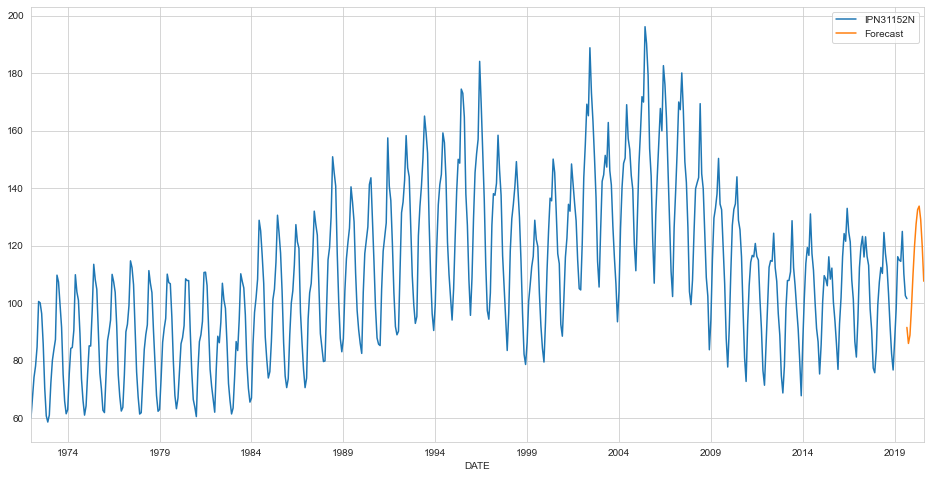

In [138]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

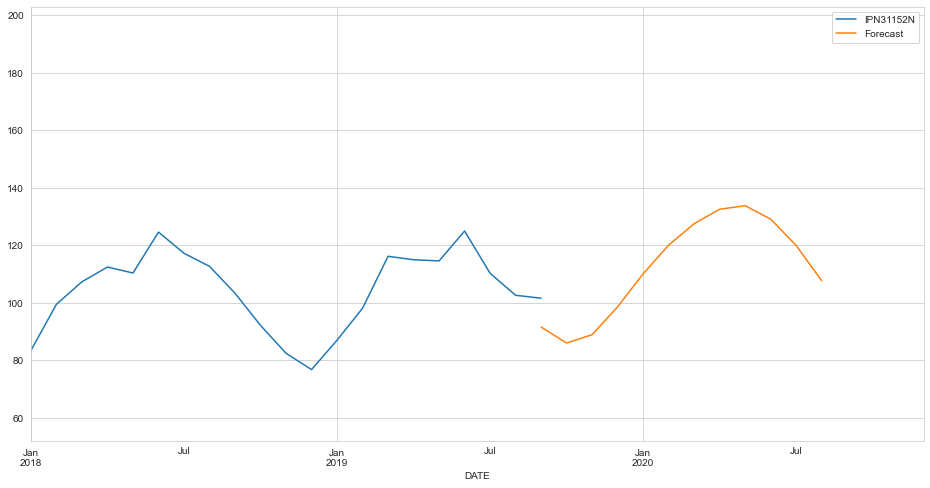

In [139]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')